# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [39]:
#package import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

1)

In [40]:
### Load data for each stock from yfinance ###
tickers = ['MSFT', 'GOOGL', 'AMZN', 'AAPL','TSLA','F', 'GM']

yf.Ticker(tickers[5]).info

start_date = dt.datetime.today() - dt.timedelta(days = 365)
end_date = dt.datetime.today()

stock = yf.download(tickers[0], start = start_date, end = end_date)



/tmp/ipython-input-40-3841586897.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers[0], start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed


In [41]:
daily_log_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_log_returns = daily_log_returns.dropna()

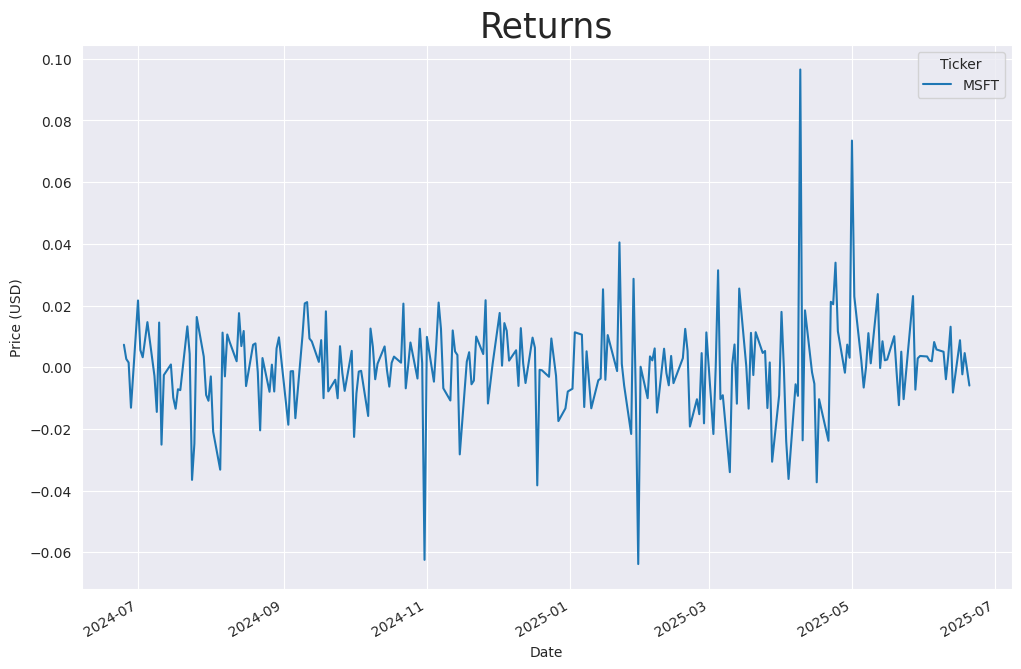

In [42]:
daily_log_returns.plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

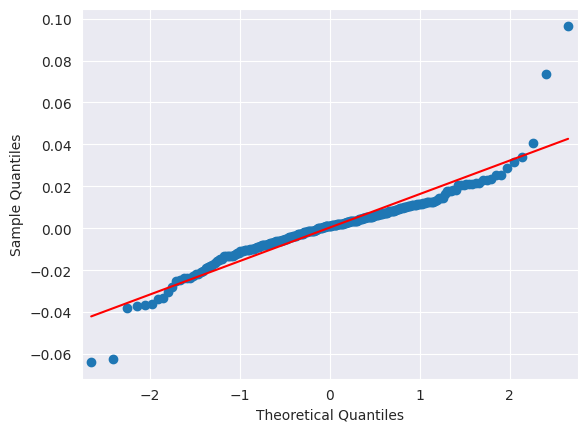

In [43]:
#Using dataframe daily_log_returns: plot the points to see if it resembles normal distribution

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Create a Q-Q plot of the 'MSFT' column
sm.qqplot(daily_log_returns['MSFT'], line='s')

# Display the plot
plt.show()

In [44]:
# prompt: Using dataframe daily_log_returns: remove the extreme cases

# Filter the DataFrame to remove rows where the 'MSFT' column is outside of 3 standard deviations from the mean
daily_log_returns = daily_log_returns[daily_log_returns['MSFT'].between(daily_log_returns['MSFT'].mean() - 3 * daily_log_returns['MSFT'].std(), daily_log_returns['MSFT'].mean() + 3 * daily_log_returns['MSFT'].std())]
daily_log_returns = daily_log_returns.dropna()

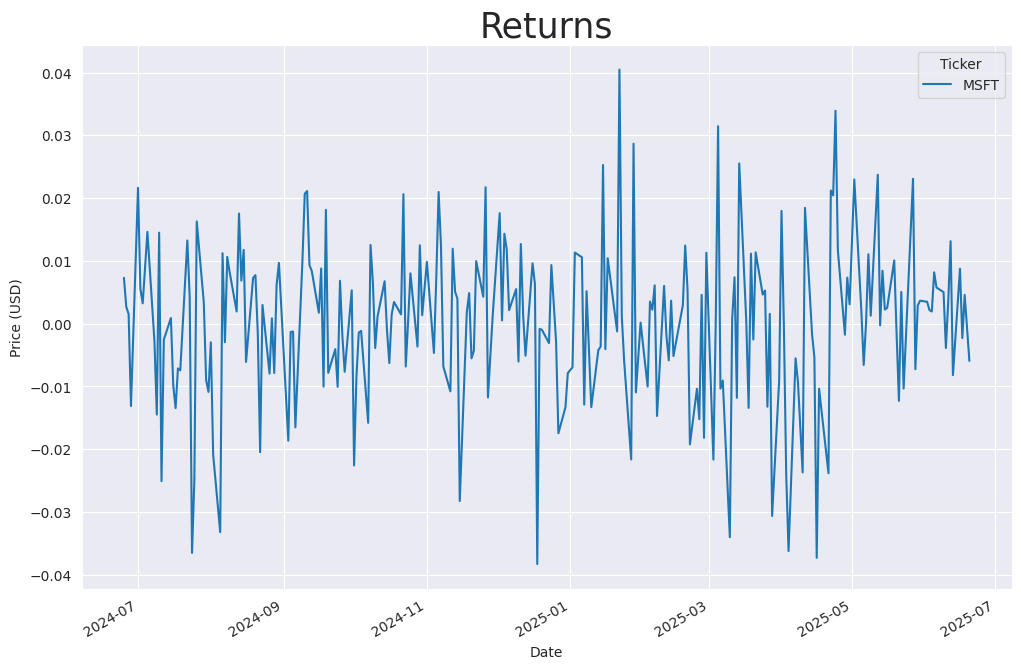

In [45]:
daily_log_returns.plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

0.000000   -0.038285
0.004115   -0.037293
0.008230   -0.036513
0.012346   -0.036214
0.016461   -0.034006
              ...   
0.983539    0.025518
0.987654    0.028672
0.991770    0.031435
0.995885    0.033901
1.000000    0.040477
Length: 244, dtype: float64


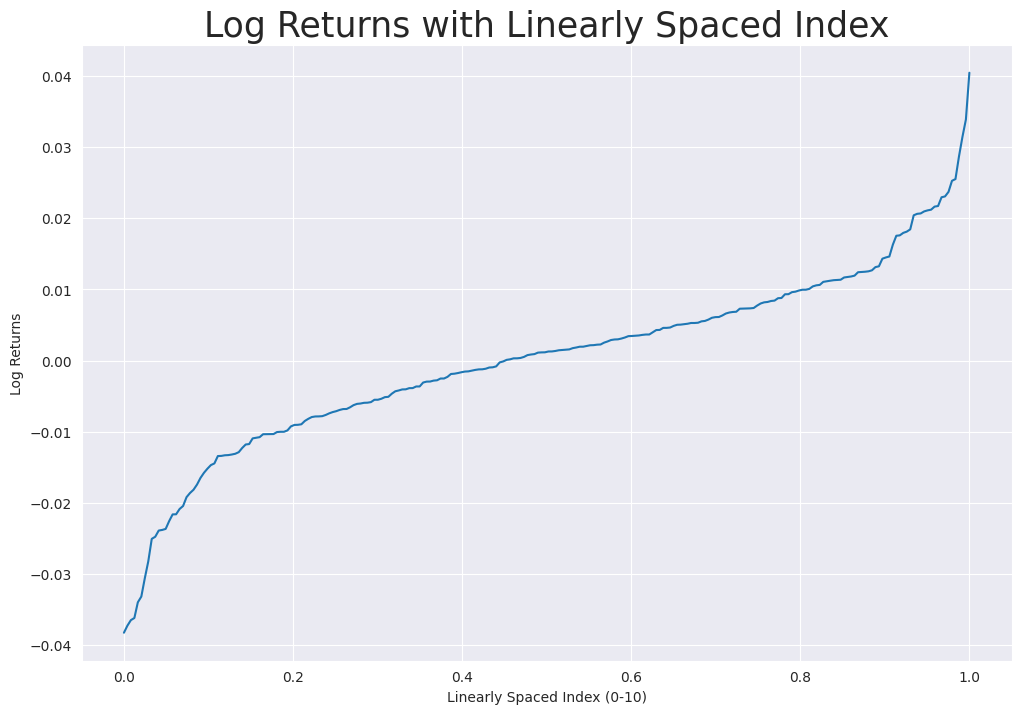

In [67]:

# Create a linearly spaced index from 0 to 10
new_index = np.linspace(0, 1, len(daily_log_returns['MSFT']))

# Create a new Series with the log returns and the new index
daily_log_returns_reindexed = pd.Series(daily_log_returns['MSFT'].sort_values().values, index=new_index)

print(daily_log_returns_reindexed)

# Plot the new Series
daily_log_returns_reindexed.plot(figsize = (12,8))
plt.title('Log Returns with Linearly Spaced Index', size = 25)
plt.xlabel('Linearly Spaced Index (0-10)')
plt.ylabel('Log Returns')
plt.show()

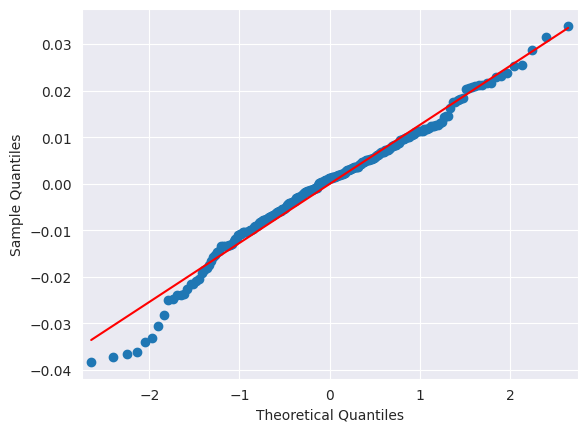

In [35]:
#Using dataframe daily_log_returns: plot the points to see if it resembles normal distribution

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Create a Q-Q plot of the 'MSFT' column
sm.qqplot(daily_log_returns['MSFT'], line='s')

# Display the plot
plt.show()

2)

3)